<a href="https://colab.research.google.com/github/YanivAmir/Ride-Hailing-Demand-Forecast/blob/main/PriceActionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
!pip install yahoo_fin
!pip install mplfinance

### Imports

In [44]:
from tvDatafeed import TvDatafeed, Interval #pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
import yfinance as yf
import yahoo_fin.stock_info as si
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import mplfinance as mpf
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
#tv = TvDatafeed("janivamir","Tyrion12tv!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data upload
Data is historic 1hr period stock price of ~6K stocks, downloaded from TradingView. Stocks contains a maximum of 5000 data points, each. Data was downloaded on a four-day period on the 17-20th of Sept 2024.

In [119]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'
with open(savePath+'TVstockData_NASDAQ_all_4803_18-20Sept2024.pickle', 'rb') as file:
        nasdaq_data = pd.read_pickle(file)
with open(savePath+'TVstockData_NYSE_all_6293_17Sept2024.pickle', 'rb') as file:
        nyse_data = pd.read_pickle(file)
data = { **nasdaq_data,**nyse_data}
print(f'Total number of stocks {len(data)}')

Total number of stocks 5850


Data are df in dictionaries with tickers as keys. Not all keys in the lists below are in the data, discontinued stocks were removed.

In [121]:
nyse_tickers = si.tickers_other()
nasdaq_tickers = si.tickers_nasdaq()
tickers = nasdaq_tickers + nyse_tickers
data[tickers[1]].head()

,symbol,open,high,low,close,volume,cap,wide_range,narrow_range/wide_range
datetime,,,,,,,,,
2021-09-27 16:30:00,NASDAQ:AADI,31.45,31.450,31.09,31.090,1200.0,37308.0,0.011447,1.000000
2021-09-27 18:30:00,NASDAQ:AADI,31.00,31.000,30.60,30.600,1019.0,31181.4,0.012903,1.000000
2021-09-27 19:30:00,NASDAQ:AADI,30.30,30.300,30.10,30.155,500.0,15077.5,0.006601,0.725000
2021-09-27 20:30:00,NASDAQ:AADI,30.16,30.355,30.16,30.300,400.0,12120.0,0.006466,0.717949
2021-09-27 21:30:00,NASDAQ:AADI,30.30,30.300,30.30,30.300,260.0,7878.0,0.000000,0.000000


## Dates and MarketCap distributions of historical stock data

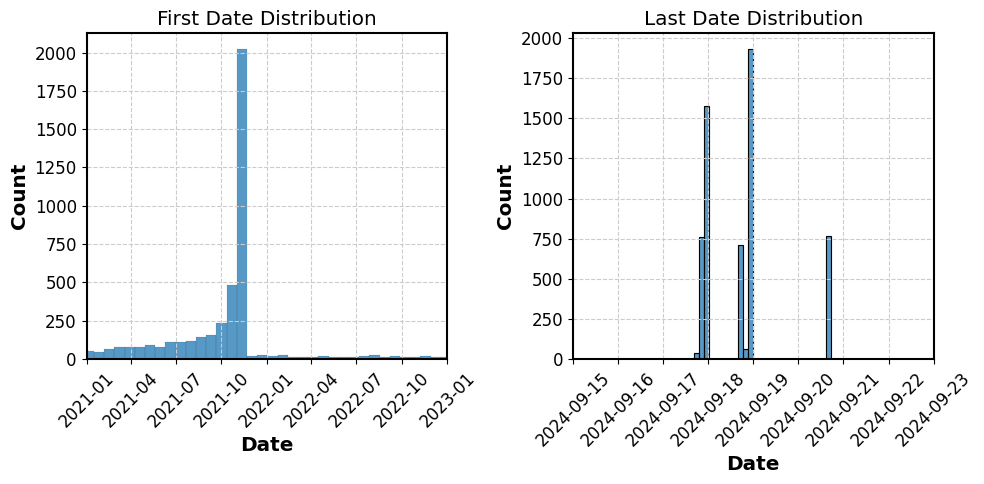

Dates less than mode date: 3716
Mode date: 2021-11-09
Count of mode date: 834


In [139]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
firstDates= [data[k].index[0] for k in data]
lastDates= [data[k].index[-1] for k in data]
sns.histplot(firstDates, ax = ax[0])
sns.histplot(lastDates, ax = ax[1])
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[0].set_title('First Date Distribution')
ax[1].set_title('Last Date Distribution')
ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[0].set_xlim((datetime(2021,1,1),datetime(2023,1,1)))
ax[1].set_xlim((datetime(2024,9,15),datetime(2024,9,23)))
plt.tight_layout()
plt.show()

# Find the most common firstdate
date_counts = Counter([dt.date() for dt in firstDates])
mode_date, mode_count = date_counts.most_common(1)[0]
count_less_than_mode = sum([1 for date in firstDates if date.date() < mode_date])
print("Dates less than mode date:", count_less_than_mode)
print("Mode date:", mode_date)
print("Count of mode date:", mode_count)

In [144]:
lengths = []
capDayMean = []
capHrMean = []
shortTickers=[]
# Assuming data[ticker] is a DataFrame with a DateTimeIndex
start_date = datetime(2021, 11, 9).date()
end_date = datetime(2024, 9, 17).date()

# Filter the DataFrame based on the date range
for i,ticker in enumerate(data):
  data[ticker] = data[ticker][(data[ticker].index.date >= start_date) & (data[ticker].index.date <= end_date)]
  lengths.append(len(data[ticker]))
  if lengths[-1]<2500:
    shortTickers.append(ticker)
  else:
    capDayMean.append(data[ticker].cap.resample('D').sum().mean())
    capHrMean.append(data[ticker].cap.mean())
  if i%500==0:
    print(i,end=' ')

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 

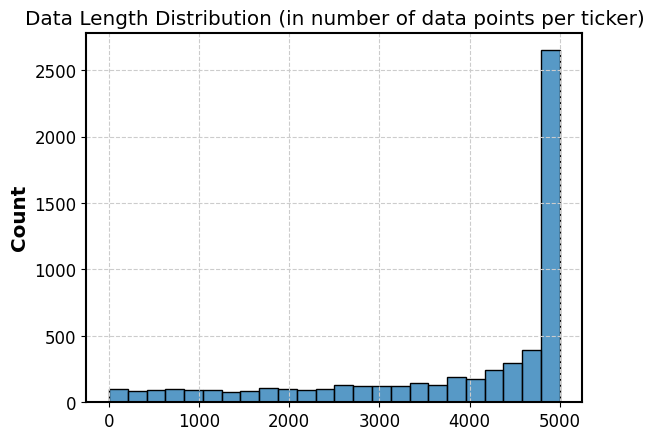

In [146]:
ax = sns.histplot(lengths)
ax.set_title('Data Length Distribution (in number of data points per ticker)')
plt.show()



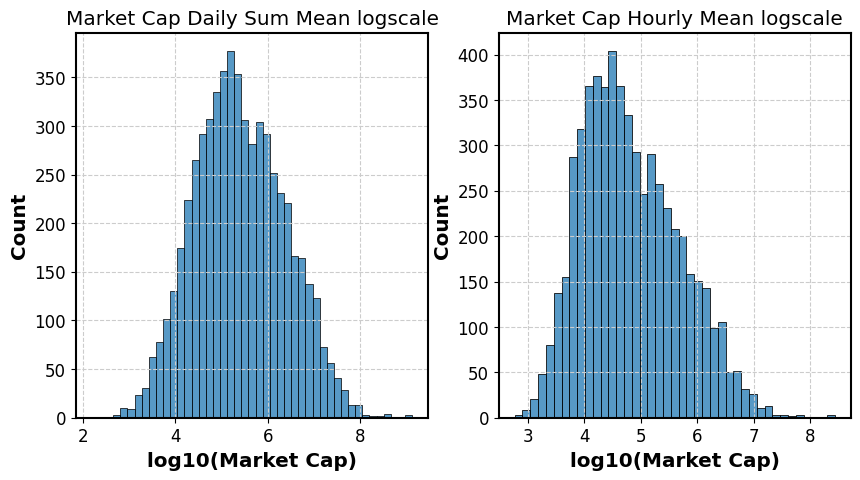

In [118]:


fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(np.log10(capDayMean), ax = ax[0])
sns.histplot(np.log10(capHrMean), ax = ax[1])
ax[0].set_title('Market Cap Daily Sum Mean logscale')
ax[1].set_title('Market Cap Hourly Mean logscale')
ax[0].set_xlabel('log10(Market Cap)')
ax[1].set_xlabel('log10(Market Cap)')
plt.show()

Filtering data on basis of:

1.   Number of time points = at least 90% of expected
2.   Average Hourly Marketcap of at least 14K (~100K daily)
3.   Average Daily Marketcap of atleat 100K

In [149]:

posTickers = [ticker for ticker in data if len(data[ticker])>4500 and np.log10(data[ticker].cap.mean())>4.15 and np.log10(data[ticker].cap.resample('D').sum().mean())>5]
print(f'Ratio of Filtered data = {round(len(posTickers)/len(data),3)}')

Ratio of Filtered data = 0.503


In [ ]:



scaledDF = deepcopy(data[ticker])
scaledDF = scaledDF.iloc[:,1:5]

st = 5 #stride in days
rng = 90 #dataRange in days
prd = 10 #predictionPeriod in days
h4d = 7
targetBuffer = 10 #time periods
minRelativePriceMove = 0.1
dpi = 64
figsize = (5, 5)
nTickers= 10
nPics4Ticker = 110

nTotalPics = nTickers*nPics4Ticker
imageData = np.zeros((nTotalPics,dpi*figsize[0],dpi*figsize[0],2))

fig1, ax1 = plt.subplots(figsize=figsize,dpi=dpi)

fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)


count = 0
indicesNotUsed=[]
start_time = time.time()
for j,ticker in enumerate(list(data.keys())[300:300+nTickers]):
  print(ticker)
  labels = np.array(data[ticker].close[435:]/data[ticker].close[4:len(data[ticker])-431].values-1)
  xaxis_close = np.linspace(0,len(data[ticker])-1-431,len(data[ticker])-431)
  xaxis_labels = np.linspace(0,len(labels)-1,len(labels))

  # Extract the volume data and corresponding dates
  volume_data = data[ticker]['cap'].values
  volume_dates = data[ticker].index


  #fig, axs = plt.subplots(12,10,figsize=(15,9), dpi=64) #120 for ALL time points, need to remove last ten so as to not to contaminate when testing

  for i in range(nPics4Ticker):
    target = np.mean(labels[i*h4d*st+h4d*rng+h4d*prd-targetBuffer:i*h4d*st+h4d*rng+h4d*prd+targetBuffer]) #stride + dataRange+ predictionPeriod +-1day (=20 hours)
    if target>minRelativePriceMove or target<-minRelativePriceMove:
      count+=1
      #print(target)
      scaler = MinMaxScaler()
      scaledDF.iloc[:,:] = scaler.fit_transform(data[ticker].iloc[:,1:5].values)
      # Plot on the primary y-axis
      priceFix = 0.5/scaledDF.iloc[i*h4d*st,0] #to make the first opening value to be 0.5
      scaledDF *= priceFix

      # Plot the OHLC chart without volume
      ax1.clear()
      mpf.plot(scaledDF.iloc[i*h4d*st:h4d*rng+h4d*st*i,:],
              type='ohlc',
              ax=ax1,
              volume=False,
              style='classic',
              show_nontrading=True)

      # Customize Plot 1: Remove gridlines, ticks, and borders
      # ax1.axis('off')
      ax1.set_ylim(0.1,1.1)
      ax1.xaxis.set_visible(False)
      ax1.yaxis.set_visible(False)
      ax1.spines['top'].set_visible(False)
      ax1.spines['bottom'].set_visible(False)
      ax1.spines['left'].set_visible(False)
      ax1.spines['right'].set_visible(False)
      #plt.show()


      fig1.canvas.draw()
      rgba_array = np.frombuffer(fig1.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
      #grey_array = 0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2]
      imageData[j,:,:,0] = (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255
      # plt.imshow(grey_array,cmap='gray')
      # plt.show()


      # Plot 2: Volume Only (with matplotlib)
      ax2.clear()
      ax2.bar(volume_dates[i*h4d*st:h4d*rng+h4d*st*i], volume_data[i*h4d*st:h4d*rng+h4d*st*i], color='black', width=0.75)

      # Customize Plot 2: Remove gridlines, ticks, and borders

      #ax2.axis('off')
      ax2.set_ylim(0,np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i]))
      ax2.set_title(int(np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i])),fontsize=10)
      ax2.xaxis.set_visible(False)
      ax2.yaxis.set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax2.spines['bottom'].set_visible(False)
      ax2.spines['left'].set_visible(False)
      ax2.spines['right'].set_visible(False)

      #plt.show()

      fig2.canvas.draw()
      rgba_array = np.frombuffer(fig2.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
      #grey_array = 0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2]
      imageData[j,:,:,1] = (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255

      if count%100 ==0:
        print(count,': ',time.time()-start_time)
  else:
    indicesNotUsed.append(i)
print('10 tickers : ',time.time()-start_time)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


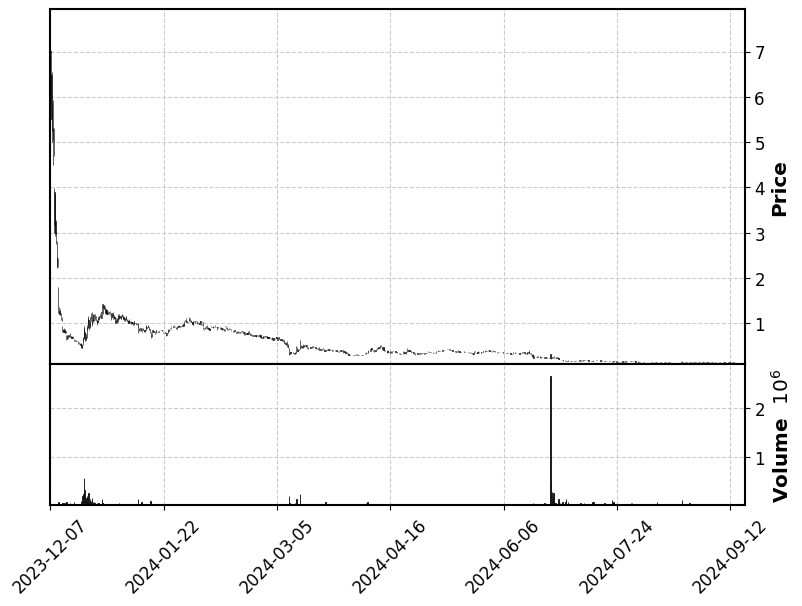

In [91]:
mpf.plot(data[shortTickers[0]],
         type='candle',
         volume=True,
         style='classic',
         datetime_format='%Y-%m-%d',  # Format for dates
         xrotation=45,                # Rotate date labels for readability
         tight_layout=True)

In [10]:

def loadAndCombineData(all_data,savePath,exchange,start_idx,interval,end_idx,day,month,year):
  print(exchange)
  date = str(day)+str(month)+str(year)
  for idx in range(start_idx,end_idx+interval,interval):
    with open(savePath+'TVstockData_'+exchange+'_'+date+'_'+str(idx)+'.pickle', 'rb') as file:
        data = pd.read_pickle(file)
    all_data = {**all_data, **data}
  return(all_data)

savePath ='/content/drive/MyDrive/myStocksSept2024/'

date = str(18)+str(9)+str(2024)
with open(savePath+'TVstockData_NASDAQ_'+date+'_1000.pickle', 'rb') as file:
        nasdaq_data = pd.read_pickle(file)
print(len(nasdaq_data))
nasdaq_data = loadAndCombineData(nasdaq_data,savePath,'NASDAQ',1000,100,3700,18,9,2024)
print(len(nasdaq_data))
nasdaq_data = loadAndCombineData(nasdaq_data,savePath,'NASDAQ',3800,100,4800,20,9,2024)
print(len(nasdaq_data))
date = str(20)+str(9)+str(2024)
with open(savePath+'TVstockData_NASDAQ_'+date+'_final_4803.pickle', 'rb') as file:
        current_data = pd.read_pickle(file)
nasdaq_data = {**nasdaq_data, **current_data}
print(len(nasdaq_data))

with open(savePath+'TVstockData_NASDAQ_all_4803_18-20Sept2024.pickle', 'wb') as file:
        pickle.dump(nasdaq_data,file)

nyse_data = loadAndCombineData({},savePath,'NYSE',1000,1000,6000,17,9,2024)
print(len(nyse_data))
date = str(17)+str(9)+str(2024)
with open(savePath+'TVstockData_NYSE_'+date+'_final_6293.pickle', 'rb') as file:
        current_data = pd.read_pickle(file)
nyse_data = {**nyse_data, **current_data}
print(len(nyse_data))

with open(savePath+'TVstockData_NYSE_all_6293_17Sept2024.pickle', 'wb') as file:
        pickle.dump(nyse_data,file)

data = { **nasdaq_data,**nyse_data}
print(len(data))

675
NASDAQ
2709
NASDAQ
3475
3477
NYSE
2282
2373
5850
